In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

# `VultureVsZealot`
- SAIDA_RL에서 작성한 document : https://teamsaida.github.io/SAIDA_RL/VultureVSZealot/ 


- VultureVsZealot 환경 분석

---
## #1. import VultureVsZealot

- `VultureVsZealot` 클래스를 import 해서 env를 만들면 학습시킬 수 있는 환경 객체가 생성된다.

In [2]:
from SAIDA_RL.python.saida_gym.starcraft.vultureVsZealot import VultureVsZealot

In [3]:
env = VultureVsZealot(version=0, frames_per_step=6, action_type=0, move_angle=15, move_dist=9, \
                      verbose=0, no_gui=False, auto_kill=False, bot_runner=r"SAIDA_RL\cpp\Release\SAIDA\SAIDA.exe")
env

Initialize...
Shared Memory create 
SAIDA_VZ2796 Shared memory found.


- env 객체를 생성하기만 해도 starcraft 환경이 켜짐. 


- `python/saida_gym/envs/SAIDAGym.py` 에서 `shm.SharedMemory()` 로 메모리를 공유하면서 바로 켜지는 것으로 보임.

---
## #2. `env`는 어떤 속성들을 가지고 있나?


In [4]:
env.__dict__.keys()

dict_keys(['verbose', 'action_type', 'map_version', 'frames_per_step', 'move_angle', 'move_dist', 'conn', 'message', 'common_message', 'init_req_msg', 'init_res_msg', 'reset_req_msg', 'reset_res_msg', 'step_req_msg', 'step_res_msg', 'close_req_msg', 'action_space', 'Terran_Vulture', 'Protoss_Zealot', 'walkableMap', 'observation_space', 'state', 'reward', 'done', 'info'])

- 하나씩 확인해보자.

### 1) 학습과 관련된 parameters

In [5]:
print("verbose:", env.verbose)
print("action_type:", env.action_type)
print("map_version:", env.map_version)
print("frames_per_step:", env.frames_per_step)
print("move_angle:", env.move_angle)
print("move_dist:", env.move_dist)
print("action_space:", env.action_space)
print("observation_space:", env.observation_space)

verbose: 0
action_type: 0
map_version: 0
frames_per_step: 6
move_angle: 15
move_dist: 9
action_space: Discrete(25)
observation_space: Discrete(31)


#### # `verbose`
- 출력되는 로그의 양 조정

#### # `action_type`
- `0` : discrete (output : descrete한 N개의 action_space 중 하나의 `integer` (0~N 중 마지막 숫자인 N은 공격))
- `1` : continuous, xy좌표 (output : `[x좌표, y좌표, action_종류(0:이동, 1:공격)]`)
- `2` : continuous, 극좌표 (output : `[theta, radian, action_종류(0:이동, 1:공격)]`)
    
#### # `map_version` 
- `0` : 1 vulture versus 1 zealot, no terrain
- `1` : 1 vulture versus 2 zealot, no terrain	
- `2` : 1 vulture versus 1 zealot, with terrain
- `3` : 1 vulture versus 2 zealot, with terrain

#### # `frames_per_step`
- 몇 frame마다 하나의 action을 결정할지에 대한 step을 결정

#### # `move_angle`
- 가장 작은 단위의 움직임 각도 단위
- `move_angle = 15` 이면 agent는 15도 단위, 즉 360/15 = 24방향으로 이동가능

#### # `move_distance` 
- 한 action에 이동할 거리
- 1 unit = 32px 

#### # `action_space` 
- `move_angle`로 나뉘어진 action 공간
- `move_angle = 15` 이면 `action_space`는 24

#### # `observation_space`
- 각 agent (자신과 적 포함) 에게서 관찰할 수 있는 모든 정보 종류의 수

### 2) starcraft server와의 connection과 관련된 parameters

In [6]:
print("conn:", env.conn)
print("message:", env.message)  # protobuf file
print("common_message:", env.common_message)  # protobuf file

conn: <saida_gym.envs.conn.shm.SharedMemory object at 0x000001C9CEEED128>
message: <module 'saida_gym.envs.protobuf.common_pb2' from 'C:\\Users\\Jeina\\SAIDA_RL\\python\\saida_gym\\envs\\protobuf\\common_pb2.py'>
common_message: <module 'saida_gym.envs.protobuf.common_pb2' from 'C:\\Users\\Jeina\\SAIDA_RL\\python\\saida_gym\\envs\\protobuf\\common_pb2.py'>


- 이 친구들은 connection과 연관이 있음 


- python 코드에서 cpp 코드로 넘어가는 부분이기도 함


- python과 cpp 간에 데이터 전송을 protobuf 라는 데이터 구조로 진행하는 것으로 보임, 완벽하게 이해는 x  


### 3) Agent와 관련된 parameters

In [7]:
print("Terran_Vulture:", env.Terran_Vulture)
print("Protoss_Zealot:", env.Protoss_Zealot)

Terran_Vulture: hp_max: 80
cooldown_max: 30
acceleration: 100
top_speed: 6.4
damage_amount: 20
damage_factor: 1
weapon_range: 160
sight_range: 256

Protoss_Zealot: hp_max: 100
shield_max: 60
armor: 1
cooldown_max: 22
acceleration: 1
top_speed: 4.0
damage_amount: 8
damage_factor: 1
weapon_range: 15
sight_range: 224
seek_range: 96



- 현재 환경은 Vulture vs Zealot 이므로 두 agent들의 속성을 담음


- 위에서 봤던 `observation_space` 는 31개이므로 원래 더 많은 속성들이 있지만, 현재 짜여진 코드에서 사용되는 것들만 보이는 듯함.

### 4) `WalkableMap`
- 전체 지도를 agent가 갈 수 있는지/없는지 True/False로 나타낸 맵

In [8]:
walkable_map = np.array(env.walkableMap)
print(walkable_map.shape)
walkable_map

(512, 512)


array([[False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       ...,
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False]])

- 사이즈는 (512, 512)로 축소되어 있음

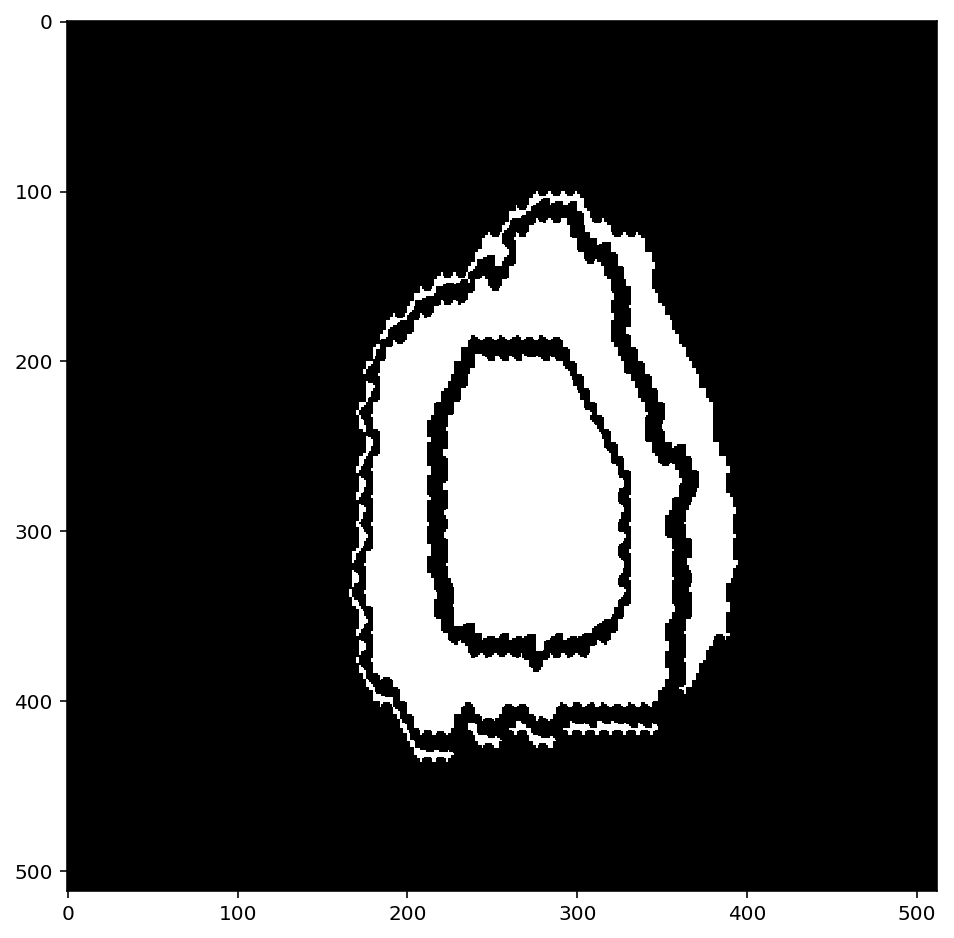

In [9]:
plt.figure(figsize=(8, 8))
plt.imshow(env.walkableMap, cmap='gray')
plt.show()

- 흰색이 walkable, 검은색은 non-walkable


- 현재의 VulltureVsZealot 맵에서는 가운데부분만 흰색인 걸로 보아 그 부분에서만 이동 가능할 것으로 보임

### 5) `state`

- 맨 처음 `env` 객체를 만든 후 state를 호출하면 아무것도 없음

In [10]:
env.state

- `env`를 한 번 reset 해줘야 env에 최초 state가 담김

In [11]:
state = env.reset()

#### # `state.my_unit`: vulture의 상태

- `pos_info`는 현재 24개의 action_space 방향에 가장 가까운 장애물(Zealot)의 거리를 나타냄

- max_distance는 320이기 때문에, 모든 값이 320으로 나타난다면 반지름이 320인 원 내에 아무런 적이 없다는 뜻

In [12]:
state.my_unit

[unit_type: "Terran_Vulture"
hp: 80
pos_x: 2176
pos_y: 2120
angle: 5.301437602932776
pos_info {
  nearest_obstacle_dist: 320
}
pos_info {
  nearest_obstacle_dist: 320
}
pos_info {
  nearest_obstacle_dist: 320
}
pos_info {
  nearest_obstacle_dist: 320
}
pos_info {
  nearest_obstacle_dist: 320
}
pos_info {
  nearest_obstacle_dist: 320
}
pos_info {
  nearest_obstacle_dist: 320
}
pos_info {
  nearest_obstacle_dist: 320
}
pos_info {
  nearest_obstacle_dist: 320
}
pos_info {
  nearest_obstacle_dist: 320
}
pos_info {
  nearest_obstacle_dist: 320
}
pos_info {
  nearest_obstacle_dist: 320
}
pos_info {
  nearest_obstacle_dist: 320
}
pos_info {
  nearest_obstacle_dist: 320
}
pos_info {
  nearest_obstacle_dist: 320
}
pos_info {
  nearest_obstacle_dist: 320
}
pos_info {
  nearest_obstacle_dist: 320
}
pos_info {
  nearest_obstacle_dist: 320
}
pos_info {
  nearest_obstacle_dist: 320
}
pos_info {
  nearest_obstacle_dist: 320
}
pos_info {
  nearest_obstacle_dist: 320
}
pos_info {
  nearest_obstacle_dis

#### # `en_unit` : 적, Zealot의 상태
- 적은 pos_info값이 없음

In [13]:
state.en_unit

[unit_type: "Protoss_Zealot"
hp: 100
shield: 60
pos_x: 2403
pos_y: 2131
angle: 1.3744467859455345
]

### 6) `reward`, `done`, `info`

In [14]:
env.reward

0

- agent의 보상값 (zealot을 죽이면 양의 보상을 받을 것으로 예상)

In [15]:
env.done

0

- episode가 끝났는지에 대한 boolean값

- vulture나 zealot 중 하나가 죽으면 끝날 것으로 예상

In [16]:
env.info

{}